<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_3_venice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 1.

In [5]:
#!pip install umap-learn

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import  pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
from time import time as timer
import os
import tarfile

import tensorflow as tf

%matplotlib inline
import umap
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler

2023-09-28 17:13:06.889514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Check if the 'data' directory does not exist in the current working directory
if not os.path.exists('data'):
    # Construct the path to the tarball file in the current working directory
    path = os.path.abspath('.') + '/colab_material.tgz'

    # Download the tarball file from a GitHub repository and save it to the specified path
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')

    # Open the downloaded tarball file in read-only mode with gzip compression
    tar = tarfile.open(path, "r:gz")

    # Extract all the contents of the tarball archive into the current working directory
    tar.extractall()

    # Close the tarball file to release associated resources
    tar.close()


In [14]:
from utils.routines import *

In [10]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)


def house_prices_dataset_normed():
    # Call the 'house_prices_dataset' function to get the dataset features and labels
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)

    # Create a StandardScaler object to normalize the dataset features
    scaler = StandardScaler()

    # Fit the scaler to the dataset features and transform them
    features_scaled = scaler.fit_transform(x)

    # Return the normalized features
    return features_scaled


**CLUSTERING Objective:** 

Clustering techniques divide the set of data into group of points having common features. Each data point $p$ gets assigned a label $l_p \in \{1,..,K\}$ representing the group to which it belongs. In this presentation the data points are supposed to have $D$ features.

**General Caveat:** 

Clustering techniques rely on a a-priori fixed notion of 'distance' between the points. This implies:

- The default distance is called `euclidean`: $d(x_p,x_{q})=\sqrt{\sum_{i} |x_{p,i}-x_{q,i}|^{2}}$. This distance is not invariant if we change units, if all features have difference units. One way to keep on using the default euclidean distance is normalizing variables.

- Other ad-hoc distance may be defined depending on the use-case scenario.

- Results of clustering must always be checked by experts of the field of interest. Clustering is an iterative process.

Note that if your data is labelled (e.g. each label is assigned to a class), the number of groups can be different than the number of classes. 

# 1. Non-linear dimensionality reduction

- Non-linear dimensionality reduction techniques can be used to map the original set of points with $D$ features into 2 features.

- PCA also offers such a mapping (take the first two relevant scores) but in general two components are not enough to conserve the variance. This happens because PCA limits itself to new features that are `linear combinations` of the old one

- Non-linear dimensionality reduction techniques do not pose themselves such a constraint and therefore can map data into very low dimensions (for example 2)

- If we have a map in 2D we can visualize clusters by eye

`t-Sne` and `UMAP` are the two most popular dimensionality reduction techniques. They differ in the type of information that is preserved before and after the mapping.

- `t-Sne` uses a `statistical description` of the environment of a sample point ;
- `UMAP` conserves the `connectivity` (topological) properties of the environment of a sample point ;

The projection on the low-dimensional space is optimized in order to match as much as possible the description of the local environment.

It is not the goal of this introduction to discuss the derivation of such approaches, which can be found in the references:

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

https://arxiv.org/pdf/1802.03426.pdf

Results between UMAP and t-Sne shoud be comparable.

In [44]:
# Load the MNIST dataset using the tf.keras.datasets API
mnist = tf.keras.datasets.mnist

# Unpack the dataset into training and testing data and labels
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Define the number of examples you want to use (5000 in this case)
n_examples = 5000

# Select the first n_examples training images and reshape them into a flat format
# Each image in the MNIST dataset is 28x28 pixels, so we reshape to (n_examples, 784)
data = train_images[:n_examples, :].reshape(n_examples, -1)

# Normalize the pixel values of the data to a range between 0 and 1
data = data / 255.0

# Select the corresponding labels for the first n_examples training examples
labels = train_labels[:n_examples]

In [ ]:
# Takes a long time to run (don't run it on Google Colab)
'''

# Create a TSNE model with specified parameters
tsne_model = TSNE(
    perplexity=10,               # Perplexity parameter controls balance between preserving global and local structure
    n_components=2,              # Number of dimensions in the reduced space (2 for 2D projection)
    learning_rate=200,           # Learning rate for optimization
    early_exaggeration=4.0,      # Early exaggeration factor for optimization
    init='pca',                  # Initialization method ('pca' for principal component analysis)
    n_iter=2000,                 # Maximum number of iterations
    random_state=2233212,        # Random seed for reproducibility
    metric='euclidean',          # Metric for measuring distances ('euclidean' for Euclidean distance)
    verbose=100,                 # Verbosity level for progress updates
    n_jobs=1                     # Number of CPU cores to use for optimization (-1 for all available cores)
)

# Fit the TSNE model to the input data and perform dimensionality reduction
tsne_mnist = tsne_model.fit_transform(data)

# Create a scatter plot of the transformed data points
# - 'tsne_mnist[:, 0]' selects the first dimension after reduction
# - 'tsne_mnist[:, 1]' selects the second dimension after reduction
# - 'c=labels' assigns colors based on the labels (e.g., different colors for different categories)
# - 's=10' sets the marker size to 10
plt.scatter(tsne_mnist[:, 0], tsne_mnist[:, 1], c=labels, s=10)

# Display the scatter plot
plt.show()

'''


 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_mnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/mnist.png" width="100%"/> |
 |  -----:| -----:|

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


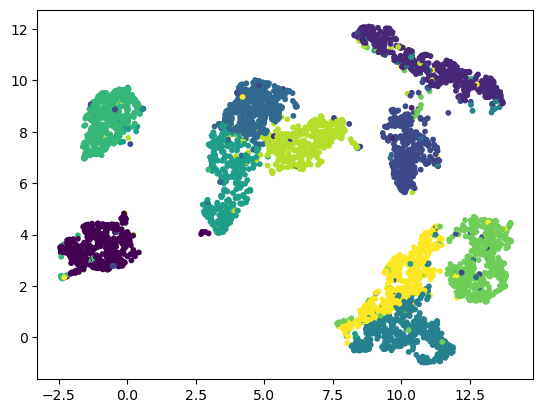

In [45]:
# Import the UMAP library for dimensionality reduction
import umap
# Import the necessary libraries for data visualization
import matplotlib.pyplot as plt

# Create a UMAP model with specified parameters
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1711)

# Fit the UMAP model to the data and perform dimensionality reduction
umap_mnist = umap_model.fit_transform(data)

# Create a scatter plot of the reduced data points
# - 'umap_mnist[:, 0]' selects the first dimension after reduction
# - 'umap_mnist[:, 1]' selects the second dimension after reduction
# - 'c=labels' assigns colors based on the labels (e.g., different colors for different digit classes)
# - 's=10' sets the marker size to 10
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=labels, s=10)

# Display the scatter plot
plt.show()


In [11]:
data=house_prices_dataset_normed()

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


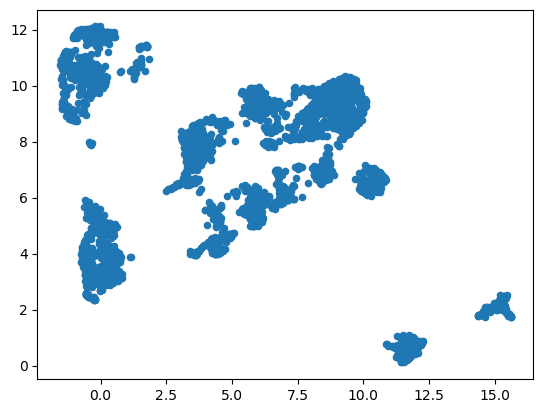

In [12]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)
plt.show()

Note: Remember that the numbers on these axes don't actually mean anything because I am not controlling how the dimensionality reduction is done (unlike PCA, in which we do). The only information from the plot above (up to this point) is that "there are clusters in my data", I don't know yet what data points these clusters are made of or any more information at all. 

## 2. K-Means

Consider first that you know the number of groups over which you want to divide your data. For example $K=3$ or $K=10$ groups. 

***Cluster centers***

K-means heavily relies on the concept of `cluster centers`. Each group gets assigned a cluster center, as a mean representative point. The centroids are given by the expression:

$$\mathbf{c}_k=\frac{1}{N_k}\sum_{p \in S_k} \mathbf{x_p}$$

where $S_k$ is the subset of points assigned to the same group $k$ and $N_k$ is the number of points in $S_k$. So, what is $S_k$? We can understand it with a few examples:

- If the data cloud (set) is made of images, the centroids are the essentially mean images, i.e. images that at each pixel contain the mean pixel value of each pixel across all images of a cluster. 

- If the data cloud is made of questionnaires, it is the mean value assigned to an answer by all questionnaires belonging to that group.

- If the data cloud is made of pressure sensors, it assigns to each sensor the mean pressure over all timespans belonging to that group

$K-Means$ assigns data points to a single group/cluster centre. All points for which the closest cluster centre belongs to class $K$, is assigned to class/group $K$ as well.


***Loss function***

The cluster centres are chosen in order to minimize the following loss function:

$$\sum_{k \in \text{classes}} \sum_{p \in S_k} d(\mathbf{x}_p,\mathbf{c}_{k})^2$$

where $S_k$ is the subset of points assigned to the same group $k$.

d is the metric function suited of the problem of interest. Here we use the Euclidean distance as a metric :

$$d(\mathbf{x}_p,\mathbf{c}_{k})=|\mathbf{x}_p-\mathbf{c}_{k}| \quad \quad $$


Such an algorithm finds local minima and may need to be started several times with different initializations.

**Vary the number of classes and validate the clustering**

*Silhouette score*: K-means clustering fixes the number of clusters a priori. Some technique must be chosen to score the different optimal clusterings for different $k$. One technique chooses the best *Silouhette score*. Intuitively, this evaluates the typical distance of points within a same clusters and compares it against the typical distance of points belonging to neighboring but different clusters ( https://en.wikipedia.org/wiki/Silhouette_(clustering) ).


### Sklearn: implementation and usage of K-means.

We start with a 2D example that can be visualized.

First we load the data-set.

In [15]:
points=km_load_th1()

Explore the data-set checking the dataset dimensionality.

In [20]:
print(points.shape)
print('We have ', points.shape[0], 'points with', points.shape[1], 'features')

(120, 2)
We have  120 points with 2 features


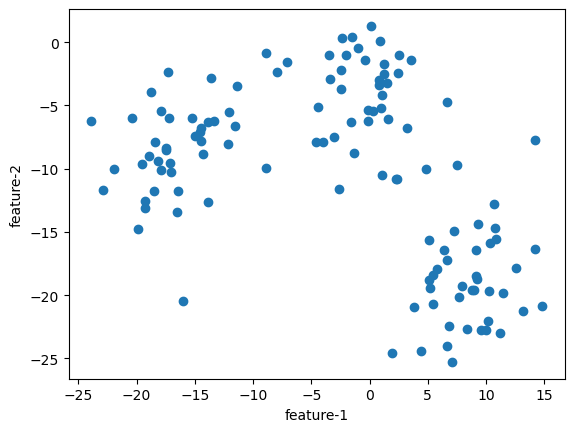

In [21]:
plt.plot(points[:,0],points[:,1],'o')
plt.xlabel('feature-1')
plt.ylabel('feature-2')
plt.show()

It looks visually that the data set has three clusters. We will cluster them using K-means. As usual, we create a KMeans object. Note that we do not need to initialize it with a data-set.

In [46]:
# Create a KMeans clusterer with specified parameters
clusterer = KMeans(
    n_clusters=3,       # Number of clusters to form
    random_state=10      # Random seed for reproducibility
)

A call to the fit method computes the cluster centers which can be plotted alongside the data-set. They are accessible from the cluster_centers_ attribute:

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


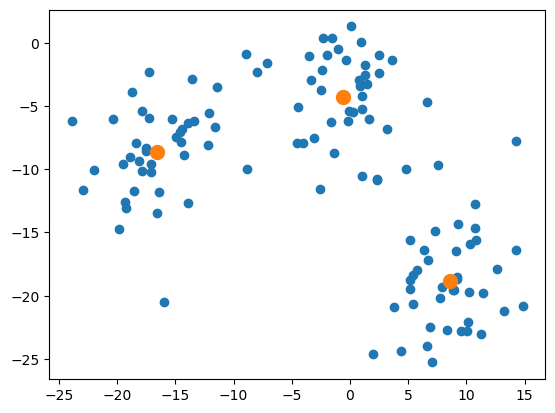

In [47]:
# Fit the KMeans clusterer to the data points
clusterer.fit(points)

# Create a scatter plot of the data points using 'o' markers
plt.plot(points[:, 0], points[:, 1], 'o')

# Plot the cluster centers as 'o' markers with larger size (markersize=10)
plt.plot(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1], 'o', markersize=10)

# Display the plot
plt.show()

In [24]:
clusterer.cluster_centers_[:,:]

array([[  8.5901409 , -18.82448838],
       [-16.59659661,  -8.6652939 ],
       [ -0.62089021,  -4.27748903]])

The predict method assigns a new point to the nearest cluster. We can use predict with the training dataset and color the data-set according to the cluster label.

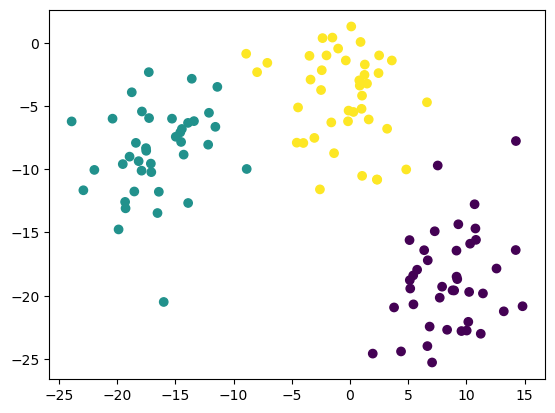

In [25]:
cluster_labels=clusterer.predict(points)
plt.scatter(points[:,0],points[:,1],c=cluster_labels)
plt.show()

Finally, we can try to vary the number of clusters and **score them with the Silhouette score.**

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


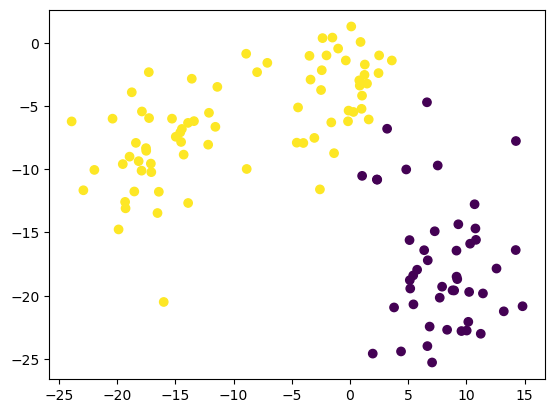

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


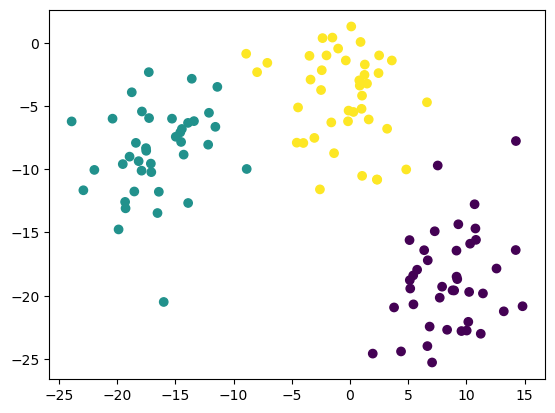

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


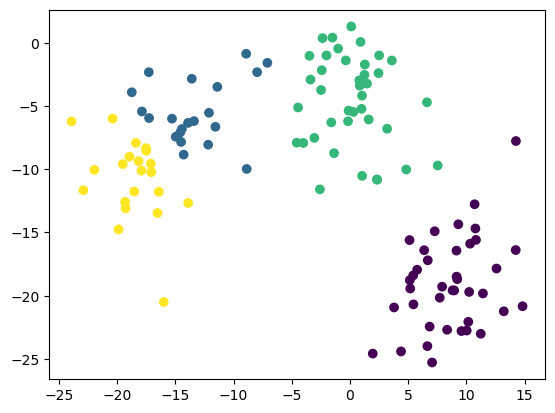

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


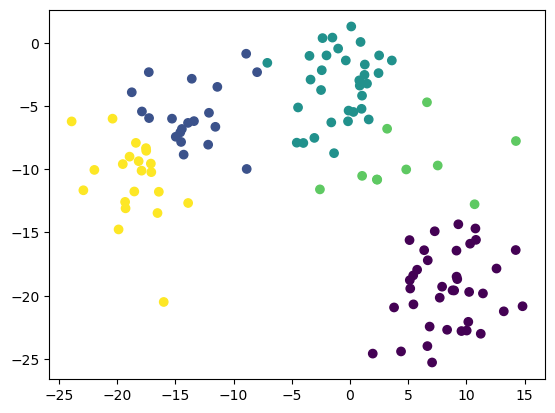

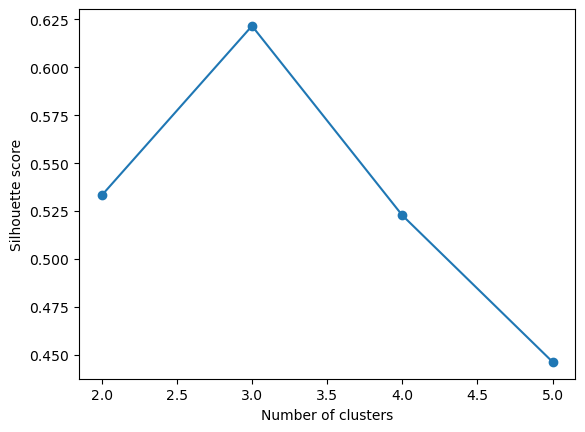

In [26]:
sil=[]

for iclust in range(2,6):
    clusterer = KMeans(n_clusters=iclust, random_state=10)
    cluster_labels = clusterer.fit_predict(points)
    score=silhouette_score(points,cluster_labels)
    sil.append(score)
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    plt.show()
    
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()

The same techniques can be used on high dimensional data-sets. We use here the famous MNIST dataset for integer digits, that we are downloading from tensorflow.

In [27]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

X=train_images[:5000,:].reshape(5000,-1)

(5000, 784)


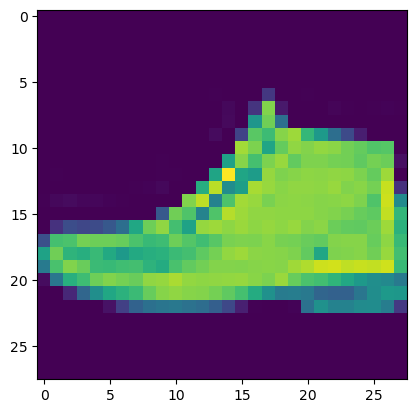

In [28]:
print(X.shape)
image=X[1232,:].reshape(28,28)
plt.imshow(image)

We can cluster the images exactly as we did for the 2d dataset.

In [29]:
clusterer = KMeans(n_clusters=10, random_state=10)
cluster_labels = clusterer.fit_predict(X)

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We can plot the cluster centers (which are 2D figures!) to see if the clustering is learning correct patterns! 

(10, 784)
There are 10 mean images, each with 784 pixels, i.e. 28 x 28


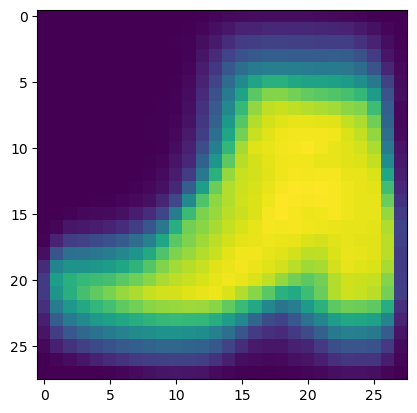

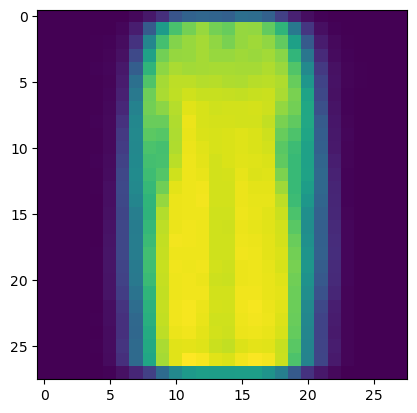

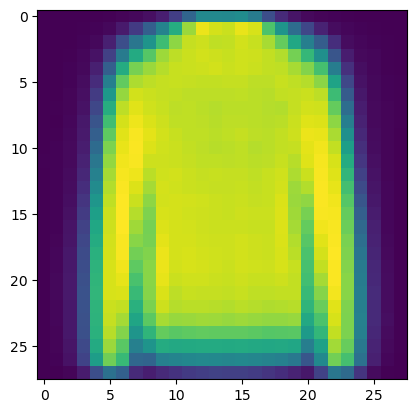

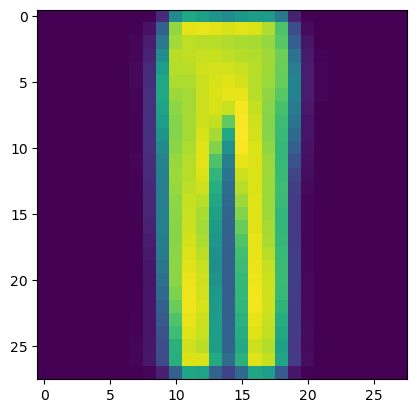

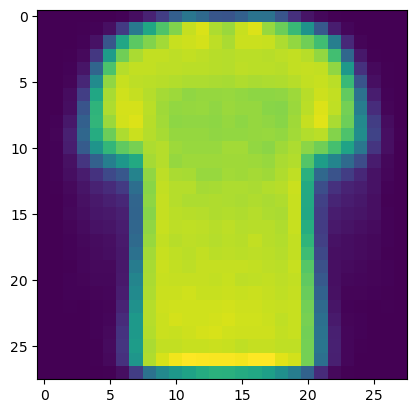

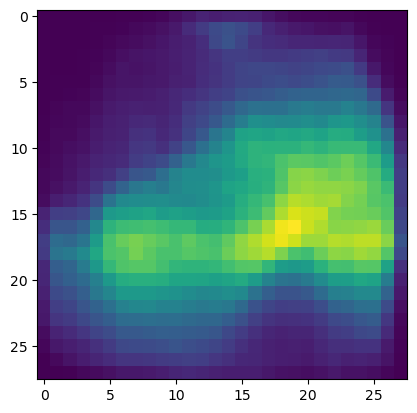

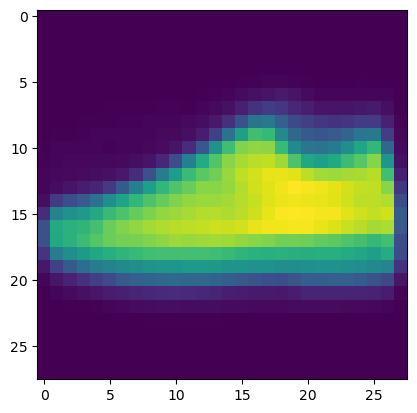

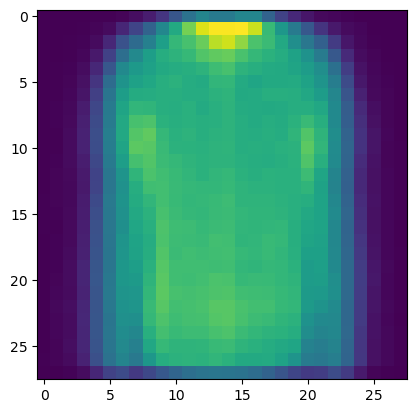

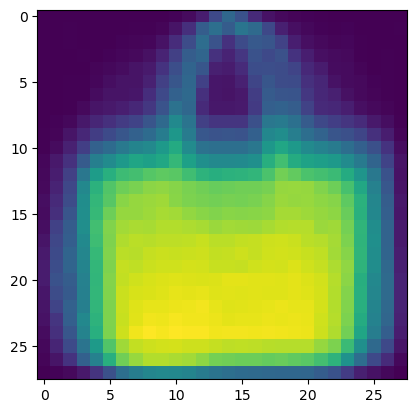

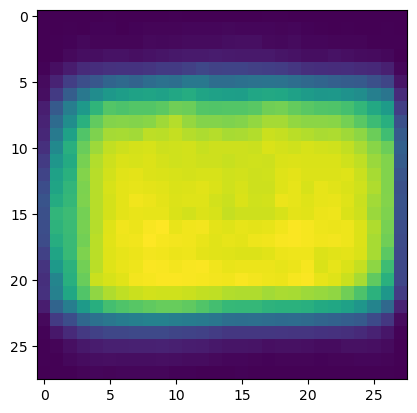

In [41]:
import math

print(clusterer.cluster_centers_.shape)
n_images, n_pixels = clusterer.cluster_centers_.shape
pixel_side_length = int(math.sqrt(n_pixels))
print(f'There are {n_images} mean images, each with {n_pixels} pixels, i.e. {pixel_side_length} x {pixel_side_length}')

for iclust in range(10):
    plt.imshow(clusterer.cluster_centers_[iclust].reshape(28,28))
    plt.show()

You can see that the model is trying to assign one class to each group.

## 3. Dendograms (hierarchical clustering)

**Objective:** 

In hierarchical clustering we do not have only an optimal set of clusters, but for each different "length scale" we have a different set of clusters.

**Algorithm:** 

- We start with a length scale $l=0$ at the beginning and consider all sample elements as different clusters.

- We increase than $l$ to values larger than zero. Let's call the minimum distance between a pair of points $l_0$. As soon as we reach $l=l_0$, these elements are merged into a new cluster (greedy strategy). 

To proceed further we need to define a distance between subsets $S_1,S_2$ of points. In the "single linkage" flavour we define:

$$d(S_1,S_2)=min_{a\in S_1, b\in S_2} d(a,b)$$

- This way we can proceed increasing $l>l_0$. As soon as we find two clusters with distance smaller than $l_1>l_0$, we merge them. 

- We keep on increasing $l$ as far as one one cluster remains

The result of this clustering procedure can be summarized in a `dendrogram`

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy
from ipywidgets import interact
from scipy.cluster.hierarchy import fcluster

points=km_load_th1()
Z = hierarchy.linkage(points, 'single')
n_clusters=int(np.max(Z[:,[0,1]].flatten()))
print(n_clusters)

@interact
def plot(t=(0,7,0.1)):  
    fig, axes=plt.subplots(1,2,figsize=(15,10), gridspec_kw={'width_ratios': [1, 2]})
    fl = fcluster(Z,t=t,criterion='distance')
    maps={}
    for clust in range(n_clusters):
        maps[clust]=(fl==clust)
    c=0
    for clust in range(n_clusters):
        if np.sum(maps[clust])>0:
            c+=1
    plt.figure(figsize=(19,5))
    d = hierarchy.dendrogram(Z,ax=axes[1], color_threshold=t)
    axes[1].axhline(t,linestyle='--',color='red')
    axes[1].set_ylabel('Cluster distance')
    axes[1].axes.get_xaxis().set_visible(False)
    axes[1].set_xlabel('Points')
    axes[1].set_title(f'Number clusters: {c}')
    axes[0].scatter(points[d['leaves'],0],points[d['leaves'],1], color=d['leaves_color_list'])


237


interactive(children=(FloatSlider(value=3.0, description='t', max=7.0), Output()), _dom_classes=('widget-inter…

**Properties:** 

If we fix a certain cutoff length $l_c$, the clusters identified $C_1,...,C_n$ at that length are such that : 

1- The constintute a disjoint partition of the whole dataset, i.e. they are mutually non intersecting aand each point belongs to a cluster 

2- The distance between two clusters $d(C_1,C_j)$ is larger than $l_c$ for each $i,j$. 


## 4. Gaussian mixtures (soft clustering)

### Theory overview.

K-Means is a modelling procedure which is biased towards clusters of circular shape and therefore does not always work perfectly, as the following examples show:

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


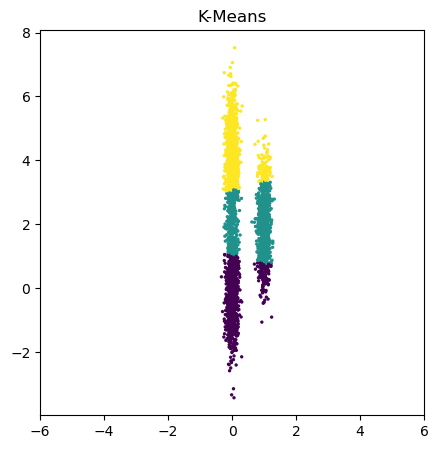

In [48]:
points=gm_load_th1()
clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal')
plt.title('K-Means')
plt.xlim(-6,6)
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


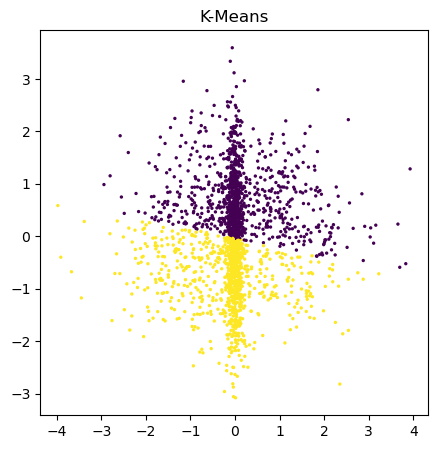

In [49]:
points=gm_load_th2()
clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.title('K-Means')
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)

A Gaussian mixture model is able to fit these kinds of clusters. In a Gaussian mixture model, each point of the distribution is supposed to be a random point from a distribution given by a superposition of Gaussians:

$$f(\mathbf{x})=\sum_c \pi_c N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x})$$

Each Gaussian describes the shape of each group, that may be also non spherical or tilted.

This density has the following interpretation. Suppose each data point $\hat{X}$ results from the following 2-step procedure:

1- First choose a random number between $\{1,...,N_c\}$ using some prior probabilities $\{\pi_1,...\pi_{N_c}\}$. This random variable says to what group a the point belong.

2- Now we extract the features corresponding to that point $\hat{X}$ using the corresponding density $N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x})$.

The parameters $\{\pi_c,\mathbf{\mu_c},\mathbf{\Sigma_c}\}$ are fitted from the data using a minimization procedure (maximum likelihood via the EM algorithm) and $N_c$ is the chosen number of clusters.



**Output of a GM computation:** 

Given the features of a new point we can reverse engineer the probability that this point was extracted one group or the other.

- *Cluster probabilities:* A gaussian mixtures model is an example of soft clustering, where each data point $p$ does not get assigned a unique cluster, but a distribution over clusters $f_p(c), c=1,...,N_c$. 

- *AIC/BIC:* after each clustering two numbers are returned. These can be used to select the optimal number of Gaussians to be used, similar to the Silhouette score. ( AIC and BIC consider both the likelihood of the data given the parameters and the complexity of the model related to the number of Gaussians used ). The lowest AIC or BIC value is an indication of a good fit.

### Sklearn: implementation and usage of Gaussian mixtures

First of all, we see how the Gaussian model behaves on our original example:

In [ ]:
points=km_load_th1()

aic=[]
bic=[]
sil=[]

for i_comp in range(2,6):
    plt.figure()
    plt.title(str(i_comp))
    clf = GaussianMixture(n_components=i_comp, covariance_type='full')
    clf.fit(points)
    cluster_labels=clf.predict(points)
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    print(i_comp,clf.aic(points),clf.bic(points))
    score=silhouette_score(points,cluster_labels)
    aic.append(clf.aic(points))
    bic.append(clf.bic(points))
    sil.append(score)
    plt.show()

In [ ]:
plt.plot(np.arange(2,6),aic,'-o')
plt.title('aic')
plt.grid()
plt.show()

plt.plot(np.arange(2,6),bic,'-o')
plt.title('bic')
plt.grid()
plt.show()

plt.plot(np.arange(2,6),sil,'-o')
plt.title('silhouette')
plt.show()

So in this case we get a comparable result, and also the probabilistic tools agree with the Silhouette score ! Let's see how the Gaussian mixtures behave in the examples where K-means was failing.

In [ ]:
points=gm_load_th1()
clf = GaussianMixture(n_components=3, covariance_type='full')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal')
plt.title('K-Means')
plt.xlim(-6,6)
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

In [ ]:
points=gm_load_th2()
clf = GaussianMixture(n_components=2, covariance_type='full')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

# Final comments

We covered here the most basic clustering techniques, showcasing different behaviors. For real like projects, there are also other algorithms that could be taken into consideration, e.g. a popular algorithm is HDBSCAN:

- HDBSCAN : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

whose main characteristics is that it defines automatically an optimal number of clusters. HDBSCAN can fit clusters of also weirder shapes. It is often used in combination to a non-linear dimensionality reduction methodology like UMAP.

Ultimately, the best way to measure the quality of a cluster is by visual inspecting its elements and see if they make sense domain-wise.